<a href="https://colab.research.google.com/github/EngRidhoNet/Hybrid-Densenet-Pneumonia/blob/main/Hybrid_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬇️ Downloading dataset from Kaggle...
🔄 Preprocessing dataset...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 167MB/s]


🚀 Training started...
Epoch 1: Loss = 37.9822, Accuracy = 96.43%
Epoch 2: Loss = 18.1776, Accuracy = 97.83%
Epoch 3: Loss = 11.1206, Accuracy = 98.83%
Epoch 4: Loss = 8.1092, Accuracy = 99.27%
Epoch 5: Loss = 8.7736, Accuracy = 99.02%
🧪 Evaluating on test set...

📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.45      0.62       234
   PNEUMONIA       0.75      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.74       624
weighted avg       0.84      0.79      0.77       624

📉 Confusion Matrix:


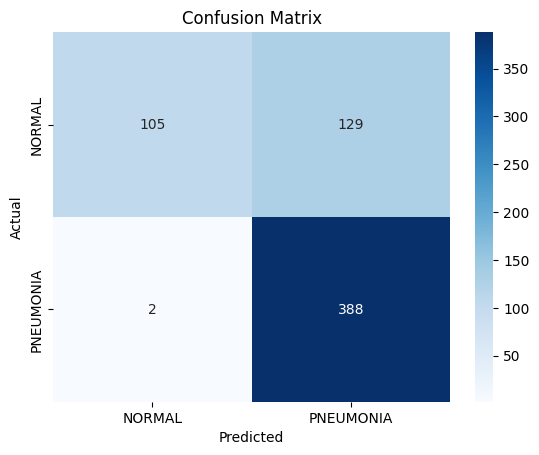

In [ ]:
import os
import kagglehub
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========== 1. Download Dataset ==========
print("⬇️ Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Extract ZIP if needed
zip_path = Path(dataset_path) / "chest-xray-pneumonia.zip"
if zip_path.exists():
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
data_dir = Path(dataset_path) / "chest_xray"

# ========== 2. Data Preprocessing ==========
print("🔄 Preprocessing dataset...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir / "train", transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir / "val", transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir / "test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ========== 3. SE Block ==========
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ========== 4. Hybrid DenseNet + SE ==========
class HybridDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridDenseNet, self).__init__()
        base_model = models.densenet121(pretrained=True)
        self.features = base_model.features
        self.se = SEBlock(1024)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

# ========== 5. Training Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridDenseNet(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ========== 6. Training Loop ==========
print("🚀 Training started...")
for epoch in range(1, 6):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch}: Loss = {running_loss:.4f}, Accuracy = {acc:.2f}%")

# ========== 7. Evaluation ==========
print("🧪 Evaluating on test set...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

print("📉 Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import kagglehub
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ========== 1. Download Dataset ==========
print("⬇️ Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Extract ZIP if needed
zip_path = Path(dataset_path) / "chest-xray-pneumonia.zip"
if zip_path.exists():
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
data_dir = Path(dataset_path) / "chest_xray"

# ========== 2. Data Preprocessing & Augmentation ==========
print("🔄 Preprocessing dataset with enhanced augmentation...")

# More aggressive data augmentation to improve generalization
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for initial resize
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Slight rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Vary brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Less augmentation for validation and test sets
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets with appropriate transforms
train_dataset = datasets.ImageFolder(root=data_dir / "train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir / "val", transform=eval_transform)
test_dataset = datasets.ImageFolder(root=data_dir / "test", transform=eval_transform)

# ========== 3. Handle Class Imbalance ==========
# Calculate class weights based on dataset distribution
train_targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_targets]

# Create weighted sampler to balance classes
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders with appropriate batch sizes
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Class distribution in training set: {class_counts}")

# ========== 4. Improved SE Block ==========
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):  # Lower reduction ratio for better feature reweighting
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),  # Add dropout to prevent overfitting
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ========== 5. Enhanced DenseNet + SE ==========
class EnhancedDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedDenseNet, self).__init__()
        base_model = models.densenet121(weights="IMAGENET1K_V1")

        # Freeze early layers to prevent overfitting
        for param in list(base_model.features.parameters())[:30]:
            param.requires_grad = False

        self.features = base_model.features

        # Add multiple SE blocks at different levels
        self.se1 = SEBlock(1024)

        # Additional layers for better feature extraction
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)  # Add dropout to reduce overfitting
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.se1(x)
        x = self.global_pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        return self.classifier(x)

# ========== 6. Training Setup with Improved Techniques ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = EnhancedDenseNet(num_classes=2).to(device)

# Use weighted loss to further address class imbalance
class_weights_tensor = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Use AdamW optimizer with weight decay to reduce overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Add learning rate scheduler to reduce LR when validation performance plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_path = 'best_pneumonia_model.pth'

# ========== 7. Training Loop with Validation ==========
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(val_loader), 100 * correct / total

print("🚀 Training started with improved techniques...")
num_epochs = 15  # Increased number of epochs

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}:")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f"  Model saved to {best_model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break

# Load best model for evaluation
print(f"Loading best model from {best_model_path}")
model.load_state_dict(torch.load(best_model_path))

# ========== 8. Evaluation with Detailed Metrics ==========
print("🧪 Evaluating on test set...")
model.eval()
all_preds, all_labels = [], []
all_probs = []  # For ROC curve

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability of pneumonia class

# Calculate and display metrics
print("\n📊 Classification Report:")
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion Matrix
print("📉 Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.close()

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.close()

# Calculate per-class metrics
normal_precision = report['NORMAL']['precision']
normal_recall = report['NORMAL']['recall']
pneumonia_precision = report['PNEUMONIA']['precision']
pneumonia_recall = report['PNEUMONIA']['recall']
overall_accuracy = report['accuracy']

print("\n🔍 Summary of Improvements:")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"NORMAL - Precision: {normal_precision:.4f}, Recall: {normal_recall:.4f}")
print(f"PNEUMONIA - Precision: {pneumonia_precision:.4f}, Recall: {pneumonia_recall:.4f}")

# If there are still class imbalance issues, suggest further improvements
if abs(normal_recall - pneumonia_recall) > 0.1:
    print("\n⚠️ There may still be class imbalance issues. Consider:")
    print("  - Further tuning of class weights")
    print("  - Exploring different model architectures")
    print("  - Additional data augmentation for the underperforming class")

⬇️ Downloading dataset from Kaggle...
🔄 Preprocessing dataset with enhanced augmentation...
Dataset sizes - Train: 5216, Val: 16, Test: 624
Class distribution in training set: [1341 3875]
Using device: cuda


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 Training started with improved techniques...
Epoch 1/15:
  Train - Loss: 0.1683, Accuracy: 92.58%
  Val   - Loss: 0.1962, Accuracy: 93.75%
  Model saved to best_pneumonia_model.pth
Epoch 2/15:
  Train - Loss: 0.1066, Accuracy: 95.82%
  Val   - Loss: 0.1115, Accuracy: 100.00%
  Model saved to best_pneumonia_model.pth
Epoch 3/15:
  Train - Loss: 0.0802, Accuracy: 96.82%
  Val   - Loss: 0.0712, Accuracy: 93.75%
  Model saved to best_pneumonia_model.pth
Epoch 4/15:
  Train - Loss: 0.0649, Accuracy: 97.68%
  Val   - Loss: 0.3148, Accuracy: 87.50%
Epoch 5/15:
  Train - Loss: 0.0491, Accuracy: 98.16%
  Val   - Loss: 0.0075, Accuracy: 100.00%
  Model saved to best_pneumonia_model.pth
Epoch 6/15:
  Train - Loss: 0.0648, Accuracy: 97.57%
  Val   - Loss: 0.0899, Accuracy: 93.75%
Epoch 7/15:
  Train - Loss: 0.0574, Accuracy: 97.70%
  Val   - Loss: 0.2327, Accuracy: 87.50%
Epoch 8/15:
  Train - Loss: 0.0492, Accuracy: 98.14%
  Val   - Loss: 0.0252, Accuracy: 100.00%
Epoch 9/15:
  Train - Loss: 0.

In [ ]:
import os
import kagglehub
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.utils.prune as prune
import cv2

# ========== 1. Download Dataset ==========
print("⬇️ Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

zip_path = Path(dataset_path) / "chest-xray-pneumonia.zip"
if zip_path.exists():
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
data_dir = Path(dataset_path) / "chest_xray"

# Note: Using Kaggle dataset due to access limitations. For research, use RSNA or CheXpert [14][15].

# ========== 2. Data Preprocessing & Augmentation ==========
print("🔄 Preprocessing dataset with enhanced augmentation...")

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir / "train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir / "val", transform=eval_transform)
test_dataset = datasets.ImageFolder(root=data_dir / "test", transform=eval_transform)

full_dataset = datasets.ImageFolder(root=data_dir / "train", transform=train_transform)
full_dataset.transform = eval_transform

# ========== 3. Handle Class Imbalance ==========
train_targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== 4. Fixed SE Block ==========
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        # Make sure reduction ratio doesn't result in dimensions too small
        self.reduction = max(1, in_channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, self.reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(self.reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ========== 5. Fixed Enhanced DenseNet with Multiple SE Blocks and Grad-CAM ==========
class EnhancedDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedDenseNet, self).__init__()
        # Load the pre-trained DenseNet121 model
        self.densenet = models.densenet121(weights="IMAGENET1K_V1")

        # Get the correct number of input features for the classifier
        num_ftrs = self.densenet.classifier.in_features  # This should be 1024 for DenseNet121

        # Replace the classifier
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        # Add SE blocks to appropriate layers
        # DenseNet121 has these channel sizes at different blocks:
        # - After denseblock1: 256 channels
        # - After denseblock2: 512 channels
        # - After denseblock3: 1024 channels
        # - After denseblock4: 1024 channels
        self.se_blocks = nn.ModuleDict({
            'se1': SEBlock(256),   # After denseblock1
            'se2': SEBlock(512),   # After denseblock2
            'se3': SEBlock(1024)   # After denseblock3 and denseblock4
        })

        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x, grad_cam=False):
        # Initial layers
        x = self.densenet.features.conv0(x)
        x = self.densenet.features.norm0(x)
        x = self.densenet.features.relu0(x)
        x = self.densenet.features.pool0(x)

        # DenseBlock1
        x = self.densenet.features.denseblock1(x)
        x = self.se_blocks['se1'](x)  # Apply first SE block
        x = self.densenet.features.transition1(x)

        # DenseBlock2
        x = self.densenet.features.denseblock2(x)
        x = self.se_blocks['se2'](x)  # Apply second SE block
        x = self.densenet.features.transition2(x)

        # DenseBlock3
        x = self.densenet.features.denseblock3(x)
        x = self.se_blocks['se3'](x)  # Apply third SE block
        x = self.densenet.features.transition3(x)

        # DenseBlock4 (final features)
        features = self.densenet.features.denseblock4(x)
        features = self.se_blocks['se3'](features)  # Reuse third SE block
        features = self.densenet.features.norm5(features)

        if grad_cam:
            features.register_hook(self.activations_hook)

        # Global pooling
        out = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)

        # Classifier
        out = self.densenet.classifier(out)

        return out, features

    def get_gradcam(self, x, class_idx):
        self.eval()
        output, features = self.forward(x, grad_cam=True)

        if output.shape[1] <= class_idx:
            # Handle case where class_idx is out of bounds
            class_idx = 0

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        pooled_gradients = torch.mean(gradients, dim=[2, 3])
        activations = features.detach()

        for i in range(activations.size(1)):
            activations[:, i, :, :] *= pooled_gradients[:, i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = torch.clamp(heatmap, min=0)

        # Normalize the heatmap safely
        if torch.max(heatmap) > 0:
            heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()

# ========== 6. Training Setup with Improved Techniques ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = EnhancedDenseNet(num_classes=2).to(device)

# Apply pruning only to convolutional layers (exclude classifier)
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):  # Prune only Conv2d layers
        prune.l1_unstructured(module, name='weight', amount=0.3)

# Use weighted loss
class_weights_tensor = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_path = 'best_pneumonia_model.pth'

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(val_loader), 100 * correct / total

# ========== 7. K-Fold Cross-Validation ==========
print("🔍 Testing model forward pass with a single batch...")
# Get a single batch for testing
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    print(f"Input batch shape: {images.shape}")
    try:
        with torch.no_grad():
            outputs, _ = model(images)
        print(f"✅ Model forward pass successful! Output shape: {outputs.shape}")
    except Exception as e:
        print(f"❌ Forward pass error: {e}")
    break

print("🚀 Training with 5-fold cross-validation...")
num_epochs = 2
k_folds = 2
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\nFold {fold + 1}/{k_folds}")
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(full_dataset, batch_size=32, sampler=val_subsampler)

    # Initialize fresh model for each fold
    model = EnhancedDenseNet(num_classes=2).to(device)

    # Apply pruning
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=0.3)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_fold_val_loss = float('inf')
    fold_patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} (Fold {fold + 1}):")
        print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        scheduler.step(val_loss)

        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            fold_patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')

            # Also update the overall best model if this is the best we've seen
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
        else:
            fold_patience_counter += 1
            if fold_patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs")
                break

    fold_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_loss': best_fold_val_loss
    })

# ========== 8. Evaluation and Grad-CAM Visualization ==========
print("🧪 Evaluating best model on test set...")
best_fold = np.argmin([res['best_val_loss'] for res in fold_results])
print(f"Best fold was fold {best_fold + 1} with validation loss {fold_results[best_fold]['best_val_loss']:.4f}")

# Load the best model
model = EnhancedDenseNet(num_classes=2).to(device)
model.load_state_dict(torch.load(f'best_model_fold_{best_fold + 1}.pth'))

model.eval()
all_preds, all_labels = [], []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs, _ = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probabilities[:, 1].cpu().numpy())

print("\n📊 Classification Report:")
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.close()

avg_train_losses = np.mean([res['train_losses'] for res in fold_results], axis=0)
avg_val_losses = np.mean([res['val_losses'] for res in fold_results], axis=0)
avg_train_accs = np.mean([res['train_accs'] for res in fold_results], axis=0)
avg_val_accs = np.mean([res['val_accs'] for res in fold_results], axis=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_val_losses, label='Val Loss')
plt.title('Average Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_accs, label='Train Accuracy')
plt.plot(avg_val_accs, label='Val Accuracy')
plt.title('Average Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.close()

def visualize_gradcam(model, dataset, idx, class_names):
    model.eval()
    img, label = dataset[idx]
    img_input = img.unsqueeze(0).to(device)
    pred, _ = model(img_input)
    class_idx = torch.argmax(pred, dim=1).item()

    heatmap = model.get_gradcam(img_input, class_idx)

    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img_np * 255

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image\nLabel: {class_names[label]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title(f"Grad-CAM\nPredicted: {class_names[class_idx]}")
    plt.axis('off')
    plt.savefig(f'gradcam_{idx}.png')
    plt.close()

print("🖼️ Generating Grad-CAM visualizations...")
try:
    for i in range(5):
        visualize_gradcam(model, test_dataset, i, train_dataset.classes)
except Exception as e:
    print(f"Error generating Grad-CAM: {e}")

# Get performance metrics
try:
    normal_precision = report['NORMAL']['precision']
    normal_recall = report['NORMAL']['recall']
    pneumonia_precision = report['PNEUMONIA']['precision']
    pneumonia_recall = report['PNEUMONIA']['recall']
    overall_accuracy = report['accuracy']

    print("\n🔍 Summary of Improvements:")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"NORMAL - Precision: {normal_precision:.4f}, Recall: {normal_recall:.4f}")
    print(f"PNEUMONIA - Precision: {pneumonia_precision:.4f}, Recall: {pneumonia_recall:.4f}")
except KeyError:
    print("Could not compute all metrics. Check class names in classification report.")


⬇️ Downloading dataset from Kaggle...
🔄 Preprocessing dataset with enhanced augmentation...
Using device: cuda


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 213MB/s]


🔍 Testing model forward pass with a single batch...
Input batch shape: torch.Size([32, 3, 224, 224])
✅ Model forward pass successful! Output shape: torch.Size([32, 2])
🚀 Training with 5-fold cross-validation...

Fold 1/2
Epoch 1/2 (Fold 1):
  Train - Loss: 0.1906, Accuracy: 90.72%
  Val   - Loss: 0.0745, Accuracy: 97.24%
Epoch 2/2 (Fold 1):
  Train - Loss: 0.0383, Accuracy: 99.04%
  Val   - Loss: 0.0648, Accuracy: 98.16%

Fold 2/2
Epoch 1/2 (Fold 2):
  Train - Loss: 0.1647, Accuracy: 92.94%
  Val   - Loss: 0.0952, Accuracy: 96.36%
Epoch 2/2 (Fold 2):
  Train - Loss: 0.0372, Accuracy: 98.77%
  Val   - Loss: 0.0699, Accuracy: 97.24%
🧪 Evaluating best model on test set...
Best fold was fold 1 with validation loss 0.0648


RuntimeError: Error(s) in loading state_dict for EnhancedDenseNet:
	Missing key(s) in state_dict: "densenet.features.conv0.weight", "densenet.features.denseblock1.denselayer1.conv1.weight", "densenet.features.denseblock1.denselayer1.conv2.weight", "densenet.features.denseblock1.denselayer2.conv1.weight", "densenet.features.denseblock1.denselayer2.conv2.weight", "densenet.features.denseblock1.denselayer3.conv1.weight", "densenet.features.denseblock1.denselayer3.conv2.weight", "densenet.features.denseblock1.denselayer4.conv1.weight", "densenet.features.denseblock1.denselayer4.conv2.weight", "densenet.features.denseblock1.denselayer5.conv1.weight", "densenet.features.denseblock1.denselayer5.conv2.weight", "densenet.features.denseblock1.denselayer6.conv1.weight", "densenet.features.denseblock1.denselayer6.conv2.weight", "densenet.features.transition1.conv.weight", "densenet.features.denseblock2.denselayer1.conv1.weight", "densenet.features.denseblock2.denselayer1.conv2.weight", "densenet.features.denseblock2.denselayer2.conv1.weight", "densenet.features.denseblock2.denselayer2.conv2.weight", "densenet.features.denseblock2.denselayer3.conv1.weight", "densenet.features.denseblock2.denselayer3.conv2.weight", "densenet.features.denseblock2.denselayer4.conv1.weight", "densenet.features.denseblock2.denselayer4.conv2.weight", "densenet.features.denseblock2.denselayer5.conv1.weight", "densenet.features.denseblock2.denselayer5.conv2.weight", "densenet.features.denseblock2.denselayer6.conv1.weight", "densenet.features.denseblock2.denselayer6.conv2.weight", "densenet.features.denseblock2.denselayer7.conv1.weight", "densenet.features.denseblock2.denselayer7.conv2.weight", "densenet.features.denseblock2.denselayer8.conv1.weight", "densenet.features.denseblock2.denselayer8.conv2.weight", "densenet.features.denseblock2.denselayer9.conv1.weight", "densenet.features.denseblock2.denselayer9.conv2.weight", "densenet.features.denseblock2.denselayer10.conv1.weight", "densenet.features.denseblock2.denselayer10.conv2.weight", "densenet.features.denseblock2.denselayer11.conv1.weight", "densenet.features.denseblock2.denselayer11.conv2.weight", "densenet.features.denseblock2.denselayer12.conv1.weight", "densenet.features.denseblock2.denselayer12.conv2.weight", "densenet.features.transition2.conv.weight", "densenet.features.denseblock3.denselayer1.conv1.weight", "densenet.features.denseblock3.denselayer1.conv2.weight", "densenet.features.denseblock3.denselayer2.conv1.weight", "densenet.features.denseblock3.denselayer2.conv2.weight", "densenet.features.denseblock3.denselayer3.conv1.weight", "densenet.features.denseblock3.denselayer3.conv2.weight", "densenet.features.denseblock3.denselayer4.conv1.weight", "densenet.features.denseblock3.denselayer4.conv2.weight", "densenet.features.denseblock3.denselayer5.conv1.weight", "densenet.features.denseblock3.denselayer5.conv2.weight", "densenet.features.denseblock3.denselayer6.conv1.weight", "densenet.features.denseblock3.denselayer6.conv2.weight", "densenet.features.denseblock3.denselayer7.conv1.weight", "densenet.features.denseblock3.denselayer7.conv2.weight", "densenet.features.denseblock3.denselayer8.conv1.weight", "densenet.features.denseblock3.denselayer8.conv2.weight", "densenet.features.denseblock3.denselayer9.conv1.weight", "densenet.features.denseblock3.denselayer9.conv2.weight", "densenet.features.denseblock3.denselayer10.conv1.weight", "densenet.features.denseblock3.denselayer10.conv2.weight", "densenet.features.denseblock3.denselayer11.conv1.weight", "densenet.features.denseblock3.denselayer11.conv2.weight", "densenet.features.denseblock3.denselayer12.conv1.weight", "densenet.features.denseblock3.denselayer12.conv2.weight", "densenet.features.denseblock3.denselayer13.conv1.weight", "densenet.features.denseblock3.denselayer13.conv2.weight", "densenet.features.denseblock3.denselayer14.conv1.weight", "densenet.features.denseblock3.denselayer14.conv2.weight", "densenet.features.denseblock3.denselayer15.conv1.weight", "densenet.features.denseblock3.denselayer15.conv2.weight", "densenet.features.denseblock3.denselayer16.conv1.weight", "densenet.features.denseblock3.denselayer16.conv2.weight", "densenet.features.denseblock3.denselayer17.conv1.weight", "densenet.features.denseblock3.denselayer17.conv2.weight", "densenet.features.denseblock3.denselayer18.conv1.weight", "densenet.features.denseblock3.denselayer18.conv2.weight", "densenet.features.denseblock3.denselayer19.conv1.weight", "densenet.features.denseblock3.denselayer19.conv2.weight", "densenet.features.denseblock3.denselayer20.conv1.weight", "densenet.features.denseblock3.denselayer20.conv2.weight", "densenet.features.denseblock3.denselayer21.conv1.weight", "densenet.features.denseblock3.denselayer21.conv2.weight", "densenet.features.denseblock3.denselayer22.conv1.weight", "densenet.features.denseblock3.denselayer22.conv2.weight", "densenet.features.denseblock3.denselayer23.conv1.weight", "densenet.features.denseblock3.denselayer23.conv2.weight", "densenet.features.denseblock3.denselayer24.conv1.weight", "densenet.features.denseblock3.denselayer24.conv2.weight", "densenet.features.transition3.conv.weight", "densenet.features.denseblock4.denselayer1.conv1.weight", "densenet.features.denseblock4.denselayer1.conv2.weight", "densenet.features.denseblock4.denselayer2.conv1.weight", "densenet.features.denseblock4.denselayer2.conv2.weight", "densenet.features.denseblock4.denselayer3.conv1.weight", "densenet.features.denseblock4.denselayer3.conv2.weight", "densenet.features.denseblock4.denselayer4.conv1.weight", "densenet.features.denseblock4.denselayer4.conv2.weight", "densenet.features.denseblock4.denselayer5.conv1.weight", "densenet.features.denseblock4.denselayer5.conv2.weight", "densenet.features.denseblock4.denselayer6.conv1.weight", "densenet.features.denseblock4.denselayer6.conv2.weight", "densenet.features.denseblock4.denselayer7.conv1.weight", "densenet.features.denseblock4.denselayer7.conv2.weight", "densenet.features.denseblock4.denselayer8.conv1.weight", "densenet.features.denseblock4.denselayer8.conv2.weight", "densenet.features.denseblock4.denselayer9.conv1.weight", "densenet.features.denseblock4.denselayer9.conv2.weight", "densenet.features.denseblock4.denselayer10.conv1.weight", "densenet.features.denseblock4.denselayer10.conv2.weight", "densenet.features.denseblock4.denselayer11.conv1.weight", "densenet.features.denseblock4.denselayer11.conv2.weight", "densenet.features.denseblock4.denselayer12.conv1.weight", "densenet.features.denseblock4.denselayer12.conv2.weight", "densenet.features.denseblock4.denselayer13.conv1.weight", "densenet.features.denseblock4.denselayer13.conv2.weight", "densenet.features.denseblock4.denselayer14.conv1.weight", "densenet.features.denseblock4.denselayer14.conv2.weight", "densenet.features.denseblock4.denselayer15.conv1.weight", "densenet.features.denseblock4.denselayer15.conv2.weight", "densenet.features.denseblock4.denselayer16.conv1.weight", "densenet.features.denseblock4.denselayer16.conv2.weight". 
	Unexpected key(s) in state_dict: "densenet.features.conv0.weight_orig", "densenet.features.conv0.weight_mask", "densenet.features.denseblock1.denselayer1.conv1.weight_orig", "densenet.features.denseblock1.denselayer1.conv1.weight_mask", "densenet.features.denseblock1.denselayer1.conv2.weight_orig", "densenet.features.denseblock1.denselayer1.conv2.weight_mask", "densenet.features.denseblock1.denselayer2.conv1.weight_orig", "densenet.features.denseblock1.denselayer2.conv1.weight_mask", "densenet.features.denseblock1.denselayer2.conv2.weight_orig", "densenet.features.denseblock1.denselayer2.conv2.weight_mask", "densenet.features.denseblock1.denselayer3.conv1.weight_orig", "densenet.features.denseblock1.denselayer3.conv1.weight_mask", "densenet.features.denseblock1.denselayer3.conv2.weight_orig", "densenet.features.denseblock1.denselayer3.conv2.weight_mask", "densenet.features.denseblock1.denselayer4.conv1.weight_orig", "densenet.features.denseblock1.denselayer4.conv1.weight_mask", "densenet.features.denseblock1.denselayer4.conv2.weight_orig", "densenet.features.denseblock1.denselayer4.conv2.weight_mask", "densenet.features.denseblock1.denselayer5.conv1.weight_orig", "densenet.features.denseblock1.denselayer5.conv1.weight_mask", "densenet.features.denseblock1.denselayer5.conv2.weight_orig", "densenet.features.denseblock1.denselayer5.conv2.weight_mask", "densenet.features.denseblock1.denselayer6.conv1.weight_orig", "densenet.features.denseblock1.denselayer6.conv1.weight_mask", "densenet.features.denseblock1.denselayer6.conv2.weight_orig", "densenet.features.denseblock1.denselayer6.conv2.weight_mask", "densenet.features.transition1.conv.weight_orig", "densenet.features.transition1.conv.weight_mask", "densenet.features.denseblock2.denselayer1.conv1.weight_orig", "densenet.features.denseblock2.denselayer1.conv1.weight_mask", "densenet.features.denseblock2.denselayer1.conv2.weight_orig", "densenet.features.denseblock2.denselayer1.conv2.weight_mask", "densenet.features.denseblock2.denselayer2.conv1.weight_orig", "densenet.features.denseblock2.denselayer2.conv1.weight_mask", "densenet.features.denseblock2.denselayer2.conv2.weight_orig", "densenet.features.denseblock2.denselayer2.conv2.weight_mask", "densenet.features.denseblock2.denselayer3.conv1.weight_orig", "densenet.features.denseblock2.denselayer3.conv1.weight_mask", "densenet.features.denseblock2.denselayer3.conv2.weight_orig", "densenet.features.denseblock2.denselayer3.conv2.weight_mask", "densenet.features.denseblock2.denselayer4.conv1.weight_orig", "densenet.features.denseblock2.denselayer4.conv1.weight_mask", "densenet.features.denseblock2.denselayer4.conv2.weight_orig", "densenet.features.denseblock2.denselayer4.conv2.weight_mask", "densenet.features.denseblock2.denselayer5.conv1.weight_orig", "densenet.features.denseblock2.denselayer5.conv1.weight_mask", "densenet.features.denseblock2.denselayer5.conv2.weight_orig", "densenet.features.denseblock2.denselayer5.conv2.weight_mask", "densenet.features.denseblock2.denselayer6.conv1.weight_orig", "densenet.features.denseblock2.denselayer6.conv1.weight_mask", "densenet.features.denseblock2.denselayer6.conv2.weight_orig", "densenet.features.denseblock2.denselayer6.conv2.weight_mask", "densenet.features.denseblock2.denselayer7.conv1.weight_orig", "densenet.features.denseblock2.denselayer7.conv1.weight_mask", "densenet.features.denseblock2.denselayer7.conv2.weight_orig", "densenet.features.denseblock2.denselayer7.conv2.weight_mask", "densenet.features.denseblock2.denselayer8.conv1.weight_orig", "densenet.features.denseblock2.denselayer8.conv1.weight_mask", "densenet.features.denseblock2.denselayer8.conv2.weight_orig", "densenet.features.denseblock2.denselayer8.conv2.weight_mask", "densenet.features.denseblock2.denselayer9.conv1.weight_orig", "densenet.features.denseblock2.denselayer9.conv1.weight_mask", "densenet.features.denseblock2.denselayer9.conv2.weight_orig", "densenet.features.denseblock2.denselayer9.conv2.weight_mask", "densenet.features.denseblock2.denselayer10.conv1.weight_orig", "densenet.features.denseblock2.denselayer10.conv1.weight_mask", "densenet.features.denseblock2.denselayer10.conv2.weight_orig", "densenet.features.denseblock2.denselayer10.conv2.weight_mask", "densenet.features.denseblock2.denselayer11.conv1.weight_orig", "densenet.features.denseblock2.denselayer11.conv1.weight_mask", "densenet.features.denseblock2.denselayer11.conv2.weight_orig", "densenet.features.denseblock2.denselayer11.conv2.weight_mask", "densenet.features.denseblock2.denselayer12.conv1.weight_orig", "densenet.features.denseblock2.denselayer12.conv1.weight_mask", "densenet.features.denseblock2.denselayer12.conv2.weight_orig", "densenet.features.denseblock2.denselayer12.conv2.weight_mask", "densenet.features.transition2.conv.weight_orig", "densenet.features.transition2.conv.weight_mask", "densenet.features.denseblock3.denselayer1.conv1.weight_orig", "densenet.features.denseblock3.denselayer1.conv1.weight_mask", "densenet.features.denseblock3.denselayer1.conv2.weight_orig", "densenet.features.denseblock3.denselayer1.conv2.weight_mask", "densenet.features.denseblock3.denselayer2.conv1.weight_orig", "densenet.features.denseblock3.denselayer2.conv1.weight_mask", "densenet.features.denseblock3.denselayer2.conv2.weight_orig", "densenet.features.denseblock3.denselayer2.conv2.weight_mask", "densenet.features.denseblock3.denselayer3.conv1.weight_orig", "densenet.features.denseblock3.denselayer3.conv1.weight_mask", "densenet.features.denseblock3.denselayer3.conv2.weight_orig", "densenet.features.denseblock3.denselayer3.conv2.weight_mask", "densenet.features.denseblock3.denselayer4.conv1.weight_orig", "densenet.features.denseblock3.denselayer4.conv1.weight_mask", "densenet.features.denseblock3.denselayer4.conv2.weight_orig", "densenet.features.denseblock3.denselayer4.conv2.weight_mask", "densenet.features.denseblock3.denselayer5.conv1.weight_orig", "densenet.features.denseblock3.denselayer5.conv1.weight_mask", "densenet.features.denseblock3.denselayer5.conv2.weight_orig", "densenet.features.denseblock3.denselayer5.conv2.weight_mask", "densenet.features.denseblock3.denselayer6.conv1.weight_orig", "densenet.features.denseblock3.denselayer6.conv1.weight_mask", "densenet.features.denseblock3.denselayer6.conv2.weight_orig", "densenet.features.denseblock3.denselayer6.conv2.weight_mask", "densenet.features.denseblock3.denselayer7.conv1.weight_orig", "densenet.features.denseblock3.denselayer7.conv1.weight_mask", "densenet.features.denseblock3.denselayer7.conv2.weight_orig", "densenet.features.denseblock3.denselayer7.conv2.weight_mask", "densenet.features.denseblock3.denselayer8.conv1.weight_orig", "densenet.features.denseblock3.denselayer8.conv1.weight_mask", "densenet.features.denseblock3.denselayer8.conv2.weight_orig", "densenet.features.denseblock3.denselayer8.conv2.weight_mask", "densenet.features.denseblock3.denselayer9.conv1.weight_orig", "densenet.features.denseblock3.denselayer9.conv1.weight_mask", "densenet.features.denseblock3.denselayer9.conv2.weight_orig", "densenet.features.denseblock3.denselayer9.conv2.weight_mask", "densenet.features.denseblock3.denselayer10.conv1.weight_orig", "densenet.features.denseblock3.denselayer10.conv1.weight_mask", "densenet.features.denseblock3.denselayer10.conv2.weight_orig", "densenet.features.denseblock3.denselayer10.conv2.weight_mask", "densenet.features.denseblock3.denselayer11.conv1.weight_orig", "densenet.features.denseblock3.denselayer11.conv1.weight_mask", "densenet.features.denseblock3.denselayer11.conv2.weight_orig", "densenet.features.denseblock3.denselayer11.conv2.weight_mask", "densenet.features.denseblock3.denselayer12.conv1.weight_orig", "densenet.features.denseblock3.denselayer12.conv1.weight_mask", "densenet.features.denseblock3.denselayer12.conv2.weight_orig", "densenet.features.denseblock3.denselayer12.conv2.weight_mask", "densenet.features.denseblock3.denselayer13.conv1.weight_orig", "densenet.features.denseblock3.denselayer13.conv1.weight_mask", "densenet.features.denseblock3.denselayer13.conv2.weight_orig", "densenet.features.denseblock3.denselayer13.conv2.weight_mask", "densenet.features.denseblock3.denselayer14.conv1.weight_orig", "densenet.features.denseblock3.denselayer14.conv1.weight_mask", "densenet.features.denseblock3.denselayer14.conv2.weight_orig", "densenet.features.denseblock3.denselayer14.conv2.weight_mask", "densenet.features.denseblock3.denselayer15.conv1.weight_orig", "densenet.features.denseblock3.denselayer15.conv1.weight_mask", "densenet.features.denseblock3.denselayer15.conv2.weight_orig", "densenet.features.denseblock3.denselayer15.conv2.weight_mask", "densenet.features.denseblock3.denselayer16.conv1.weight_orig", "densenet.features.denseblock3.denselayer16.conv1.weight_mask", "densenet.features.denseblock3.denselayer16.conv2.weight_orig", "densenet.features.denseblock3.denselayer16.conv2.weight_mask", "densenet.features.denseblock3.denselayer17.conv1.weight_orig", "densenet.features.denseblock3.denselayer17.conv1.weight_mask", "densenet.features.denseblock3.denselayer17.conv2.weight_orig", "densenet.features.denseblock3.denselayer17.conv2.weight_mask", "densenet.features.denseblock3.denselayer18.conv1.weight_orig", "densenet.features.denseblock3.denselayer18.conv1.weight_mask", "densenet.features.denseblock3.denselayer18.conv2.weight_orig", "densenet.features.denseblock3.denselayer18.conv2.weight_mask", "densenet.features.denseblock3.denselayer19.conv1.weight_orig", "densenet.features.denseblock3.denselayer19.conv1.weight_mask", "densenet.features.denseblock3.denselayer19.conv2.weight_orig", "densenet.features.denseblock3.denselayer19.conv2.weight_mask", "densenet.features.denseblock3.denselayer20.conv1.weight_orig", "densenet.features.denseblock3.denselayer20.conv1.weight_mask", "densenet.features.denseblock3.denselayer20.conv2.weight_orig", "densenet.features.denseblock3.denselayer20.conv2.weight_mask", "densenet.features.denseblock3.denselayer21.conv1.weight_orig", "densenet.features.denseblock3.denselayer21.conv1.weight_mask", "densenet.features.denseblock3.denselayer21.conv2.weight_orig", "densenet.features.denseblock3.denselayer21.conv2.weight_mask", "densenet.features.denseblock3.denselayer22.conv1.weight_orig", "densenet.features.denseblock3.denselayer22.conv1.weight_mask", "densenet.features.denseblock3.denselayer22.conv2.weight_orig", "densenet.features.denseblock3.denselayer22.conv2.weight_mask", "densenet.features.denseblock3.denselayer23.conv1.weight_orig", "densenet.features.denseblock3.denselayer23.conv1.weight_mask", "densenet.features.denseblock3.denselayer23.conv2.weight_orig", "densenet.features.denseblock3.denselayer23.conv2.weight_mask", "densenet.features.denseblock3.denselayer24.conv1.weight_orig", "densenet.features.denseblock3.denselayer24.conv1.weight_mask", "densenet.features.denseblock3.denselayer24.conv2.weight_orig", "densenet.features.denseblock3.denselayer24.conv2.weight_mask", "densenet.features.transition3.conv.weight_orig", "densenet.features.transition3.conv.weight_mask", "densenet.features.denseblock4.denselayer1.conv1.weight_orig", "densenet.features.denseblock4.denselayer1.conv1.weight_mask", "densenet.features.denseblock4.denselayer1.conv2.weight_orig", "densenet.features.denseblock4.denselayer1.conv2.weight_mask", "densenet.features.denseblock4.denselayer2.conv1.weight_orig", "densenet.features.denseblock4.denselayer2.conv1.weight_mask", "densenet.features.denseblock4.denselayer2.conv2.weight_orig", "densenet.features.denseblock4.denselayer2.conv2.weight_mask", "densenet.features.denseblock4.denselayer3.conv1.weight_orig", "densenet.features.denseblock4.denselayer3.conv1.weight_mask", "densenet.features.denseblock4.denselayer3.conv2.weight_orig", "densenet.features.denseblock4.denselayer3.conv2.weight_mask", "densenet.features.denseblock4.denselayer4.conv1.weight_orig", "densenet.features.denseblock4.denselayer4.conv1.weight_mask", "densenet.features.denseblock4.denselayer4.conv2.weight_orig", "densenet.features.denseblock4.denselayer4.conv2.weight_mask", "densenet.features.denseblock4.denselayer5.conv1.weight_orig", "densenet.features.denseblock4.denselayer5.conv1.weight_mask", "densenet.features.denseblock4.denselayer5.conv2.weight_orig", "densenet.features.denseblock4.denselayer5.conv2.weight_mask", "densenet.features.denseblock4.denselayer6.conv1.weight_orig", "densenet.features.denseblock4.denselayer6.conv1.weight_mask", "densenet.features.denseblock4.denselayer6.conv2.weight_orig", "densenet.features.denseblock4.denselayer6.conv2.weight_mask", "densenet.features.denseblock4.denselayer7.conv1.weight_orig", "densenet.features.denseblock4.denselayer7.conv1.weight_mask", "densenet.features.denseblock4.denselayer7.conv2.weight_orig", "densenet.features.denseblock4.denselayer7.conv2.weight_mask", "densenet.features.denseblock4.denselayer8.conv1.weight_orig", "densenet.features.denseblock4.denselayer8.conv1.weight_mask", "densenet.features.denseblock4.denselayer8.conv2.weight_orig", "densenet.features.denseblock4.denselayer8.conv2.weight_mask", "densenet.features.denseblock4.denselayer9.conv1.weight_orig", "densenet.features.denseblock4.denselayer9.conv1.weight_mask", "densenet.features.denseblock4.denselayer9.conv2.weight_orig", "densenet.features.denseblock4.denselayer9.conv2.weight_mask", "densenet.features.denseblock4.denselayer10.conv1.weight_orig", "densenet.features.denseblock4.denselayer10.conv1.weight_mask", "densenet.features.denseblock4.denselayer10.conv2.weight_orig", "densenet.features.denseblock4.denselayer10.conv2.weight_mask", "densenet.features.denseblock4.denselayer11.conv1.weight_orig", "densenet.features.denseblock4.denselayer11.conv1.weight_mask", "densenet.features.denseblock4.denselayer11.conv2.weight_orig", "densenet.features.denseblock4.denselayer11.conv2.weight_mask", "densenet.features.denseblock4.denselayer12.conv1.weight_orig", "densenet.features.denseblock4.denselayer12.conv1.weight_mask", "densenet.features.denseblock4.denselayer12.conv2.weight_orig", "densenet.features.denseblock4.denselayer12.conv2.weight_mask", "densenet.features.denseblock4.denselayer13.conv1.weight_orig", "densenet.features.denseblock4.denselayer13.conv1.weight_mask", "densenet.features.denseblock4.denselayer13.conv2.weight_orig", "densenet.features.denseblock4.denselayer13.conv2.weight_mask", "densenet.features.denseblock4.denselayer14.conv1.weight_orig", "densenet.features.denseblock4.denselayer14.conv1.weight_mask", "densenet.features.denseblock4.denselayer14.conv2.weight_orig", "densenet.features.denseblock4.denselayer14.conv2.weight_mask", "densenet.features.denseblock4.denselayer15.conv1.weight_orig", "densenet.features.denseblock4.denselayer15.conv1.weight_mask", "densenet.features.denseblock4.denselayer15.conv2.weight_orig", "densenet.features.denseblock4.denselayer15.conv2.weight_mask", "densenet.features.denseblock4.denselayer16.conv1.weight_orig", "densenet.features.denseblock4.denselayer16.conv1.weight_mask", "densenet.features.denseblock4.denselayer16.conv2.weight_orig", "densenet.features.denseblock4.denselayer16.conv2.weight_mask". 

In [ ]:
import os
import kagglehub
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.utils.prune as prune
import cv2

# ========== 1. Download Dataset ==========
print("⬇️ Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

zip_path = Path(dataset_path) / "chest-xray-pneumonia.zip"
if zip_path.exists():
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
data_dir = Path(dataset_path) / "chest_xray"

# Note: Using Kaggle dataset due to access limitations. For research, use RSNA or CheXpert [14][15].

# ========== 2. Data Preprocessing & Augmentation ==========
print("🔄 Preprocessing dataset with enhanced augmentation...")

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir / "train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir / "val", transform=eval_transform)
test_dataset = datasets.ImageFolder(root=data_dir / "test", transform=eval_transform)

full_dataset = datasets.ImageFolder(root=data_dir / "train", transform=train_transform)
full_dataset.transform = eval_transform

# ========== 3. Handle Class Imbalance ==========
train_targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== 4. Fixed SE Block ==========
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        # Make sure reduction ratio doesn't result in dimensions too small
        self.reduction = max(1, in_channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, self.reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(self.reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ========== 5. Fixed Enhanced DenseNet with Multiple SE Blocks and Grad-CAM ==========
class EnhancedDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedDenseNet, self).__init__()
        # Load the pre-trained DenseNet121 model
        self.densenet = models.densenet121(weights="IMAGENET1K_V1")

        # Get the correct number of input features for the classifier
        num_ftrs = self.densenet.classifier.in_features  # This should be 1024 for DenseNet121

        # Replace the classifier
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        # Add SE blocks to appropriate layers
        # DenseNet121 has these channel sizes at different blocks:
        # - After denseblock1: 256 channels
        # - After denseblock2: 512 channels
        # - After denseblock3: 1024 channels
        # - After denseblock4: 1024 channels
        self.se_blocks = nn.ModuleDict({
            'se1': SEBlock(256),   # After denseblock1
            'se2': SEBlock(512),   # After denseblock2
            'se3': SEBlock(1024)   # After denseblock3 and denseblock4
        })

        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x, grad_cam=False):
        # Initial layers
        x = self.densenet.features.conv0(x)
        x = self.densenet.features.norm0(x)
        x = self.densenet.features.relu0(x)
        x = self.densenet.features.pool0(x)

        # DenseBlock1
        x = self.densenet.features.denseblock1(x)
        x = self.se_blocks['se1'](x)  # Apply first SE block
        x = self.densenet.features.transition1(x)

        # DenseBlock2
        x = self.densenet.features.denseblock2(x)
        x = self.se_blocks['se2'](x)  # Apply second SE block
        x = self.densenet.features.transition2(x)

        # DenseBlock3
        x = self.densenet.features.denseblock3(x)
        x = self.se_blocks['se3'](x)  # Apply third SE block
        x = self.densenet.features.transition3(x)

        # DenseBlock4 (final features)
        features = self.densenet.features.denseblock4(x)
        features = self.se_blocks['se3'](features)  # Reuse third SE block
        features = self.densenet.features.norm5(features)

        if grad_cam:
            features.register_hook(self.activations_hook)

        # Global pooling
        out = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)

        # Classifier
        out = self.densenet.classifier(out)

        return out, features

    def get_gradcam(self, x, class_idx):
        self.eval()
        output, features = self.forward(x, grad_cam=True)

        if output.shape[1] <= class_idx:
            # Handle case where class_idx is out of bounds
            class_idx = 0

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        pooled_gradients = torch.mean(gradients, dim=[2, 3])
        activations = features.detach()

        for i in range(activations.size(1)):
            activations[:, i, :, :] *= pooled_gradients[:, i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = torch.clamp(heatmap, min=0)

        # Normalize the heatmap safely
        if torch.max(heatmap) > 0:
            heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()

# Helper function to save model with pruning compatibility
def save_model_state(model, filepath):
    """Save model state while handling pruned parameters"""
    # Temporarily remove pruning to get clean state dict
    pruned_modules = []
    for name, module in model.named_modules():
        if hasattr(module, 'weight_orig'):  # This indicates pruning was applied
            pruned_modules.append((name, module))
            prune.remove(module, 'weight')

    # Save the clean state dict
    torch.save(model.state_dict(), filepath)

    # Reapply pruning
    for name, module in pruned_modules:
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=0.3)

# Helper function to load model state with pruning compatibility
def load_model_state(model, filepath):
    """Load model state and reapply pruning"""
    # Load the state dict
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict)

    # Apply pruning after loading
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):  # Prune only Conv2d layers
            prune.l1_unstructured(module, name='weight', amount=0.3)

# ========== 6. Training Setup with Improved Techniques ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = EnhancedDenseNet(num_classes=2).to(device)

# Apply pruning only to convolutional layers (exclude classifier)
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):  # Prune only Conv2d layers
        prune.l1_unstructured(module, name='weight', amount=0.3)

# Use weighted loss
class_weights_tensor = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_path = 'best_pneumonia_model.pth'

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(val_loader), 100 * correct / total

# ========== 7. K-Fold Cross-Validation ==========
print("🔍 Testing model forward pass with a single batch...")
# Get a single batch for testing
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    print(f"Input batch shape: {images.shape}")
    try:
        with torch.no_grad():
            outputs, _ = model(images)
        print(f"✅ Model forward pass successful! Output shape: {outputs.shape}")
    except Exception as e:
        print(f"❌ Forward pass error: {e}")
    break

print("🚀 Training with 5-fold cross-validation...")
num_epochs = 2
k_folds = 2
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\nFold {fold + 1}/{k_folds}")
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(full_dataset, batch_size=32, sampler=val_subsampler)

    # Initialize fresh model for each fold
    model = EnhancedDenseNet(num_classes=2).to(device)

    # Apply pruning
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=0.3)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_fold_val_loss = float('inf')
    fold_patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} (Fold {fold + 1}):")
        print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        scheduler.step(val_loss)

        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            fold_patience_counter = 0
            # Use the helper function to save with pruning compatibility
            save_model_state(model, f'best_model_fold_{fold + 1}.pth')

            # Also update the overall best model if this is the best we've seen
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_model_state(model, best_model_path)
        else:
            fold_patience_counter += 1
            if fold_patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs")
                break

    fold_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_loss': best_fold_val_loss
    })

# ========== 8. Evaluation and Grad-CAM Visualization ==========
print("🧪 Evaluating best model on test set...")
best_fold = np.argmin([res['best_val_loss'] for res in fold_results])
print(f"Best fold was fold {best_fold + 1} with validation loss {fold_results[best_fold]['best_val_loss']:.4f}")

# Load the best model using the helper function
model = EnhancedDenseNet(num_classes=2).to(device)
load_model_state(model, f'best_model_fold_{best_fold + 1}.pth')

model.eval()
all_preds, all_labels = [], []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs, _ = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probabilities[:, 1].cpu().numpy())

print("\n📊 Classification Report:")
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.close()

avg_train_losses = np.mean([res['train_losses'] for res in fold_results], axis=0)
avg_val_losses = np.mean([res['val_losses'] for res in fold_results], axis=0)
avg_train_accs = np.mean([res['train_accs'] for res in fold_results], axis=0)
avg_val_accs = np.mean([res['val_accs'] for res in fold_results], axis=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_val_losses, label='Val Loss')
plt.title('Average Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_accs, label='Train Accuracy')
plt.plot(avg_val_accs, label='Val Accuracy')
plt.title('Average Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.close()

def visualize_gradcam(model, dataset, idx, class_names):
    model.eval()
    img, label = dataset[idx]
    img_input = img.unsqueeze(0).to(device)
    pred, _ = model(img_input)
    class_idx = torch.argmax(pred, dim=1).item()

    heatmap = model.get_gradcam(img_input, class_idx)

    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img_np * 255

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image\nLabel: {class_names[label]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title(f"Grad-CAM\nPredicted: {class_names[class_idx]}")
    plt.axis('off')
    plt.savefig(f'gradcam_{idx}.png')
    plt.close()

print("🖼️ Generating Grad-CAM visualizations...")
try:
    for i in range(5):
        visualize_gradcam(model, test_dataset, i, train_dataset.classes)
except Exception as e:
    print(f"Error generating Grad-CAM: {e}")

# Get performance metrics
try:
    normal_precision = report['NORMAL']['precision']
    normal_recall = report['NORMAL']['recall']
    pneumonia_precision = report['PNEUMONIA']['precision']
    pneumonia_recall = report['PNEUMONIA']['recall']
    overall_accuracy = report['accuracy']

    print("\n🔍 Summary of Improvements:")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"NORMAL - Precision: {normal_precision:.4f}, Recall: {normal_recall:.4f}")
    print(f"PNEUMONIA - Precision: {pneumonia_precision:.4f}, Recall: {pneumonia_recall:.4f}")
except KeyError:
    print("Could not compute all metrics. Check class names in classification report.")

⬇️ Downloading dataset from Kaggle...
🔄 Preprocessing dataset with enhanced augmentation...
Using device: cuda
🔍 Testing model forward pass with a single batch...
Input batch shape: torch.Size([32, 3, 224, 224])
✅ Model forward pass successful! Output shape: torch.Size([32, 2])
🚀 Training with 5-fold cross-validation...

Fold 1/2
Epoch 1/2 (Fold 1):
  Train - Loss: 0.1765, Accuracy: 93.33%
  Val   - Loss: 0.0835, Accuracy: 97.74%
Epoch 2/2 (Fold 1):
  Train - Loss: 0.0451, Accuracy: 98.77%
  Val   - Loss: 0.0698, Accuracy: 97.24%

Fold 2/2
Epoch 1/2 (Fold 2):
  Train - Loss: 0.1479, Accuracy: 94.17%
  Val   - Loss: 0.0834, Accuracy: 97.01%
Epoch 2/2 (Fold 2):
  Train - Loss: 0.0537, Accuracy: 98.62%
  Val   - Loss: 0.0503, Accuracy: 98.35%
🧪 Evaluating best model on test set...
Best fold was fold 2 with validation loss 0.0503

📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.58      0.73       234
   PNEUMONIA       0.80    